# Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import numpy as np
import csv
import tensorflow as tf
from tensorflow.keras import layers, models

import seaborn as sns
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
sign_names = []
with open("signnames.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        sign_names.append(line)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [29]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(X_train))

print("Number of training examples =", n_train)
print("Number of valid examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of valid examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 256


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

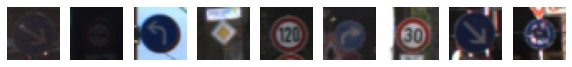

In [52]:
# Samples in train set
_, axes = plt.subplots(nrows=1, ncols=9, figsize=(10,6))
for ax in axes:
    index = np.random.randint(0, len(X_train))
    ax.axis("off")
    ax.imshow(X_train[index])

In [80]:
def display_images(nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,6))
    axes = axes.ravel()
    
    for i in range(nrows*ncols):
        index = np.random.randint(0, len(X_train))
        axes[i].axis("off")
        axes[i].imshow(X_train[index])

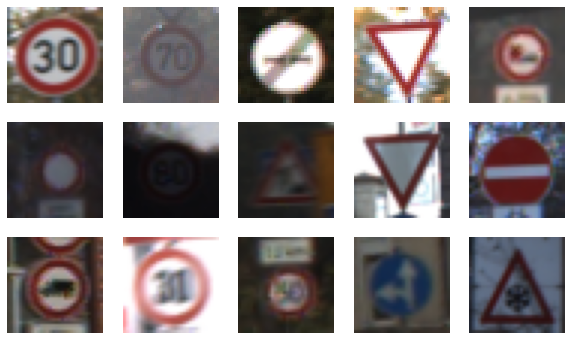

In [83]:
display_images(3,5)

In [27]:
def samples_size(train_set, title):

    fig, ax = plt.subplots(figsize=(16,5))
    sns.countplot(y_train)
    ax.set_title('Distribution of signs in '+title+' dataset', fontsize=14)
    ax.set_xlabel('Sign', fontsize=12)
    ax.set_ylabel('Count', fontsize=14)
    plt.show()

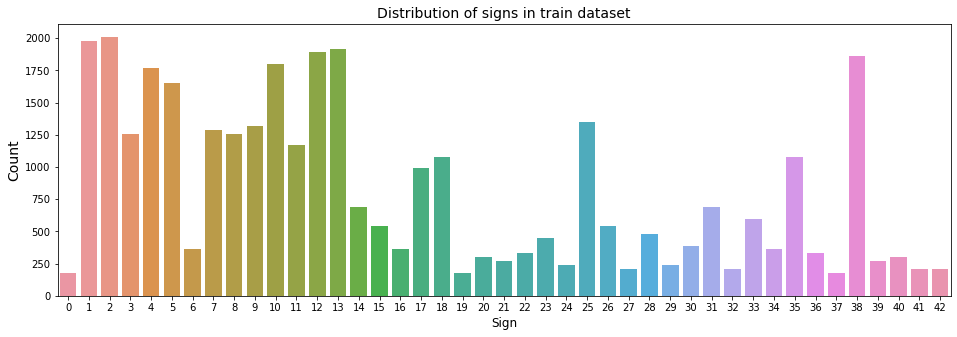

In [28]:
samples_size(y_train, "train")

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [4]:
def pre_process_image(image):

    image_gray = np.mean(image, axis=3)
    image_gray = np.expand_dims(image_gray, axis=3)
    image_norm = (image_gray - image_gray.mean())/image_gray.std()
    
    return image_norm

In [5]:
features_train = pre_process_image(X_train).astype(np.float32)
features_valid = pre_process_image(X_valid).astype(np.float32)
features_test = pre_process_image(X_test).astype(np.float32)

In [6]:
# One-Hot encoding
one_hot_y_train = tf.keras.utils.to_categorical(y_train, 43).astype(np.float32)
one_hot_y_valid = tf.keras.utils.to_categorical(y_valid, 43).astype(np.float32)
one_hot_y_test = tf.keras.utils.to_categorical(y_test, 43).astype(np.float32)

### Model Architecture

In [39]:
### Network architecture
model1 = models.Sequential()

model1.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(256, (3, 3), activation='relu'))

model1.add(layers.Flatten())

model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))

model1.add(layers.Dense(43))
model1.add(Activation('softmax'))

model1.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [40]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [41]:
# early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3)

# fitting
model1.fit(features_train, one_hot_y_train, batch_size=128, epochs=20,
          validation_data=(features_valid, one_hot_y_valid), callbacks=[callback]
            )

Epoch 1/20
272/272 [==============================] - 78s 287ms/step - loss: 2.1557 - accuracy: 0.4104 - val_loss: 0.7314 - val_accuracy: 0.8032
Epoch 2/20
272/272 [==============================] - 75s 277ms/step - loss: 0.8325 - accuracy: 0.7374 - val_loss: 0.3616 - val_accuracy: 0.9007
Epoch 3/20
272/272 [==============================] - 75s 277ms/step - loss: 0.5146 - accuracy: 0.8304 - val_loss: 0.2343 - val_accuracy: 0.9315
Epoch 4/20
272/272 [==============================] - 76s 279ms/step - loss: 0.3844 - accuracy: 0.8715 - val_loss: 0.1711 - val_accuracy: 0.9494
Epoch 5/20
272/272 [==============================] - 83s 303ms/step - loss: 0.3151 - accuracy: 0.8924 - val_loss: 0.1658 - val_accuracy: 0.9456
Epoch 6/20
272/272 [==============================] - 104s 381ms/step - loss: 0.2614 - accuracy: 0.9093 - val_loss: 0.1357 - val_accuracy: 0.9583
Epoch 7/20
272/272 [==============================] - 97s 358ms/step - loss: 0.2202 - accuracy: 0.9253 - val_loss: 0.1236 - val_a

### Test accuracy

In [42]:
test_accuracy = model1.evaluate(features_test, one_hot_y_test, verbose=0)[1]
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 0.96


In [48]:
def vis_model_preds(predictions, X_set, true_labels, n_rows=1, n_cols=4):
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15,15))
    """
    
    Shows random images and set color:
    `green` if prediction is correct
    `red` if incorrect
    
    """
    for ax in axes:
        random = np.random.randint(0, len(predictions))
        #ax.axis("off")
        ax.imshow(X_set[random])
        num_sign_labeled = true_labels[random]
        num_sign_predicted = predictions[random]
        title = sign_names[num_sign_labeled+1][1]
        if num_sign_predicted.argmax() == num_sign_labeled:
            ax.set_title(title, fontsize=12, color="green")
        else:
            ax.set_title(title, fontsize=12, color="red")

In [45]:
predicts = model.predict(features_test)

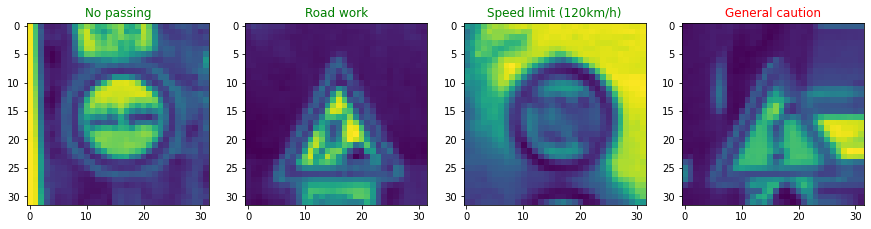

In [47]:
vis_model_preds(predicts, features_test, y_test)